# 🏁 Week 5 Tracking Analysis Of Xuan's Data

**Goal:** Using tacking data from Xuan and parsed by Appar into a CSV file to plot player paths, frame counts and movement patterns.

**🎞️ 1.1 Upload CSV Files:**

In [ ]:
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving tracking.csv to tracking.csv


**📖 1.2 Read CSV file into a dataframe (df)**

In [ ]:
import pandas as pd

df = pd.read_csv(filename)

print(f"Loaded file: {filename}")
print()
print(df.head())
print()
print(df.info())

Loaded file: tracking.csv

   frame_id  player_id  timestamp_s   x1   y1   x2   y2   cx   cy    w    h  \
0         1          1         0.00  624  478  841  964  732  721  217  485   
1         1          2         0.00  534  419  772  872  653  645  238  452   
2         2          1         0.04  613  482  807  964  710  723  193  481   
3         2          2         0.04  486  418  744  855  615  636  257  436   
4         3          1         0.08  621  483  788  968  704  725  166  484   

   confidence  
0        0.77  
1        0.74  
2        0.86  
3        0.84  
4        0.80  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   frame_id     761 non-null    int64  
 1   player_id    761 non-null    int64  
 2   timestamp_s  761 non-null    float64
 3   x1           761 non-null    int64  
 4   y1           761 non-null    int64  
 5

**🔝 Results:**

- Datasets have loaded **Successfully**.
- All data is either float or int which is **Good**.
- non-null count in each column, **Good** no missing data.

# **📑 Column Descriptions**

Each row represents a detected object (usually a player) in a single video frame. The columns mean:

- **frame_id**: The frame number from the video where the detection occurred.  
- **player_id**: The unique identifier assigned to a player by the tracking algorithm (lets us follow them across frames).  
- **timestamp_s**: The timestamp of the frame in seconds.
- **x1, y1**: The coordinates of the top left corner of the bounding box around the player.
- **x2, y2**: The coordinates of the bottom right corner of the bounding box around the player.
- **cx, cy**: The coordinated of the center of the bounding box. Calculated from x1, y1, x2, y2.  
- **w (width), h (height)**: The size of the bounding box around the player in pixels.  
- **conf**: The models confidence score for the detection (0-1).  

**❄️ 1.4 Unique Frames per  Player**

In [ ]:
player_counts = (df.groupby('player_id').size().reset_index(name='frame_count').sort_values('player_id'))
print(player_counts)

    player_id  frame_count
0           1          185
1           2           28
2           3            1
3           4            1
4           5           69
5          34            7
6          36           36
7          45            1
8          49            4
9          50          132
10         55           25
11         62          110
12         63            4
13         64           29
14         69            8
15         70            8
16         72           10
17         73            4
18         78           20
19         79           56
20         86            8
21         87            6
22         88            8
23         98            1


**🔝 Results:**
- 24 unique player_id
- player_id appear to be done by geunsy number, hence the jump from 5-34 in player_id
- player_id = 1, recorded the most amount of frame_count with 185
- player_id = 3, 4, 45, 98, recorded the least amount of frame_count with 1

**🏃‍♂️‍➡️ 1.5 Player movement path**

Here we filter the data to show the movement of a single player via their `player_id`.

- Plotting player of choice, path on cx - cy coordinates
- Each dot represents their position on one frame
- Each line is their movement from one frame to their next

Choose one of the player_id numbers from above to identify movement patterns overtime: 1


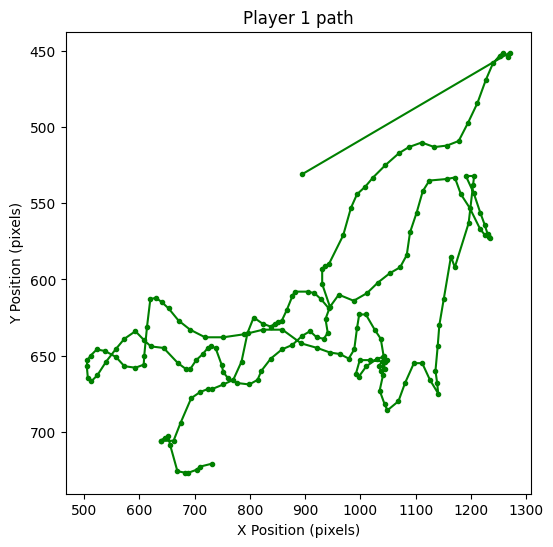

In [ ]:
import matplotlib.pyplot as plt

def plot_player_path(df):
    # Ask user which player_id to plot
    player_choice = int(input("Choose one of the player_id numbers from above to identify movement patterns overtime: "))

    p = df[df['player_id'] == player_choice].sort_values(['frame_id', 'timestamp_s'])

    plt.figure(figsize=(6,6))
    plt.plot(p['cx'], p['cy'], color='green', marker="o", markersize=3, linestyle="-")
    plt.title(f"Player {player_choice} path")
    plt.xlabel("X Position (pixels)")
    plt.ylabel("Y Position (pixels)")
    plt.gca().invert_yaxis() # Match video coordinates (y downwards?)
    plt.show()

plot_player_path(df)

# 🔥 Week 6 HeatMap Overlays

**Goal:** Use merged dataset to overlay AFL event data (kick/mark/tackle) on heatmap images. Coordinate closely with Ishita's team for frontend-ready visuals.

**💾 2.1 Install SciPy for Gaussian_filter**

The **heatmappipline.py** file uses the SciPy package for scientific computing in python, we must download in order to perform here on Google Colab.

In [ ]:
!pip -q install scipy

**🏃‍♂️‍➡️ 2.2 Run heatmappipline.py**

We now upload and run out custom `heatmappipline_xuan.py` script on the 'tracking.csv' dataset.

This script:
- Reads the player tracking data
- Scales the positions to AFL oval dimensions (165m x 135m)
- Bins the positions into a 2D grid (200 x 150 cells)
- Applies Gaussian smoothing (`sigma = 2.0`) to highlight dense areas
- Outputs per-player heatmaps into the `heatmap_outputs` directory

In [ ]:
from IPython.display import clear_output

uploaded = files.upload()
clear_output() # wipe the unnecessary log
hmfile = next(iter(uploaded))
print(f"Loaded file: {hmfile}")

Loaded file: heatmappipeline_xuan.py


In [ ]:
csv_name = "tracking.csv"
!python heatmappipeline_xuan.py \
  --inputs "{csv_name}:Xuan" \
  --out-dir heatmap_outputs \
  --weight-mode conf \
  --field-length 165 --field-width 135 \
  --nx 200 --ny 150 \
  --sigma 2.0 \
  --group-by player_id

DEBUG group-by: player_id
Done. Outputs in: /content/heatmap_outputs


**💡 2.3 Check Generated Heatmaps**

Here we scan the output folder (`heatmap_outputs`) to confirm which player heatmaps were successfully created. These are our `player_choices` options for `section 2.4`.

In [ ]:
import glob, os, re

files = glob.glob("heatmap_outputs/heatmap_*.png")
pids = []
for p in files:
    m = re.search(r"heatmap_(\d+)\.png$", os.path.basename(p))
    if m:  # only keep if the filename matches the pattern
        pids.append(int(m.group(1)))

pids = sorted(pids)
print("Player heatmaps found for IDs:", pids)

Player heatmaps found for IDs: [1, 2, 3, 4, 5, 34, 36, 45, 49, 50, 55, 62, 63, 64, 69, 70, 72, 73, 78, 79, 86, 87, 88, 98]


**🔁 2.4 Choose Player heatmap**

This function prompts the user to enter a `player_id` and then loads the corresponding pre-generated heatmap image.

- Shows movement intensity for each player on the AFL oval



Choose one of the player_id numbers from above to identify their heatmap: 1


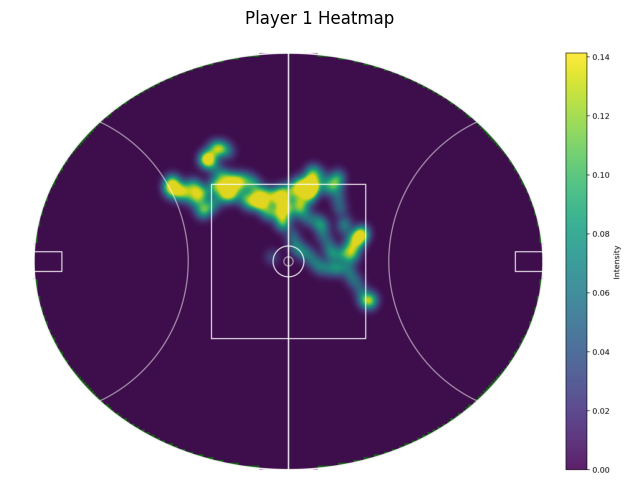

In [ ]:
import os, matplotlib.pyplot as plt
import matplotlib.image as mpimg

def player_heatmap():
  player_choice = input("Choose one of the player_id numbers from above to identify their heatmap: ").strip()

  # Build the expected file path
  filename = f"heatmap_{player_choice}.png"
  path = os.path.join("heatmap_outputs", filename)

  if not os.path.exists(path):
    print(f"No heatmap found for player {player_choice} at {path}")
    return

  img = mpimg.imread(path)
  plt.figure(figsize=(8,6))
  plt.imshow(img)
  plt.axis("off")
  plt.title(f"Player {player_choice} Heatmap")
  plt.show()

player_heatmap()


# 📋 Week 7 Compute distance, speed and heatmap participation for each player

**Goal:** Deliver JSON stats for ISHITA'S Dashboard

**🛣️ 3.1 Distance covered by each player**

In [ ]:
import numpy as np

# Ensure previous row is player's previous location
df_sorted = df.sort_values(['player_id', 'frame_id', 'timestamp_s'],    # Sorts df so for each player_id the rows are in order of appearance in video(fram_id then timestamp_s)
                           kind='mergesort').copy()                     # mergesort an effective sorting alg. .copy() makes a copy rather than changing original

# Defined oval dimensions from Flynns heatmappipeline.py file
field_length_m = 165
field_width_m = 135

# Pixel range of field
px_width = df['cx'].max() - df['cx'].min()                             # Finds how many pixels are in the length of the field
px_length  = df['cy'].max() - df['cy'].min()                           # Finds how many pixels are in the width of the field

scale_x = field_width_m / px_width                                     # How many meters per pixel i.e. 165 / 1000 = 0.165m per pixel
scale_y = field_length_m / px_length

# Convert cx, cy into metres
df_sorted['cx_m'] = (                                                   # creating a new sorted series
    df_sorted['cx']                                                     # pd series of x-coordinates in pixels
    - df_sorted['cx'].min()                                             # smallest x-pixel coordinates
    ) * scale_x                                                         # e.g. (732 - 1) * 0.165 = 120.615m / 165m down the length of the field

df_sorted['cy_m'] = (                                                   # Same again
    df_sorted['cy']
    - df_sorted['cy'].min()
    ) * scale_y                                                         # e.g. (721 - 40) * 0.165 = 112.365m / 135m across the width of the field

# Step distances in metres
dx_m = df_sorted.groupby('player_id')['cx_m'].diff()                    # For each player compute difference between x positions in meters
dy_m = df_sorted.groupby('player_id')['cy_m'].diff()                    # For each player compute difference between y position in meters

# compute distance travelled and clamp unrealistic speeds
# Using per frame distance. Anything >3 m between previous frames is treated as an outlier.
step = np.hypot(dx_m, dy_m)                                             # np.hypot() finds euclidean difference between x and y coordinates
max_step_m = 0.5                                                          # reasonable per-frame maximum at 50fps footage?
df_sorted['step_dist_m'] = np.where(np.isfinite(step) & (step <= max_step_m), step, 0.0) # Two checks: keeps only step data that is real (.isfinite) and under max step. If conditions true keep, if not replace with 0.0
df_sorted['step_dist_m'] = df_sorted['step_dist_m'].fillna(0)           # np.hypot() finds the euclidean difference between x-difference and y-difference. Fill Na's with '0'

# Total distance per player
player_distance = (
    df_sorted.groupby('player_id', as_index=False)['step_dist_m']       # Group the df by player_id so all their rows are together
    .sum()                                                              # Sum all step distances for each player
    .rename(columns={'step_dist_m': 'distance_covered_m'})              # Clearer column name
    .sort_values('player_id')                                           # Sort the rows by player_id
)

# Print results
for _, row in player_distance.iterrows():                               # Loop through each row of the summary df, iterrows lets you iterate through rows
    print(f"player_id {int(row.player_id)}: {row.distance_covered_m:.2f} m")

player_id 1: 3.60 m
player_id 2: 0.00 m
player_id 3: 0.00 m
player_id 4: 0.00 m
player_id 5: 0.44 m
player_id 34: 0.32 m
player_id 36: 0.00 m
player_id 45: 0.00 m
player_id 49: 0.00 m
player_id 50: 2.94 m
player_id 55: 0.00 m
player_id 62: 2.54 m
player_id 63: 0.00 m
player_id 64: 0.00 m
player_id 69: 0.00 m
player_id 70: 0.00 m
player_id 72: 0.00 m
player_id 73: 0.00 m
player_id 78: 0.00 m
player_id 79: 3.31 m
player_id 86: 0.24 m
player_id 87: 0.00 m
player_id 88: 0.00 m
player_id 98: 0.00 m


**🚀 3.2 Mean Speed + Max Speed of each player**

---



In [ ]:
fps = 25

# Time delta from frame gaps per player (more reliable than timestamp_s if jittery)
frame_gap = df_sorted.groupby('player_id')['frame_id'].diff()       # Groups data by player_id, finding difference between current frame and previous
dt_frames = frame_gap / fps                                         # Converts gaps between frames into actual time (seconds)

# Instantaneous speed (m/s) from clamped per-step distance
clamped_step = df_sorted['step_dist_m']                                                         # Using clamped step distance from earlier (step_dist_m)
speed_mps = np.where((dt_frames > 0) & np.isfinite(dt_frames), clamped_step / dt_frames, np.nan) # Speed formula: speed (m/s) = distance (m) / time (s). Use NaN for invalids so mean ignores them.

# Cap impossible speeds by clipping
vmax_ms = 12.0                                                                                  # Defining a maximum speed of 12 m/s (~43 km/h).
speed_mps = np.clip(speed_mps, 0, vmax_ms)                                                      # Clip speeds to [0, vmax_ms]. Keeps valid samples but prevents spikes.

df_sorted['speed_mps'] = speed_mps                                                              # Stores clean speed values into df
df_sorted['dt_s'] = np.where(np.isfinite(dt_frames) & (dt_frames > 0), dt_frames, np.nan)       # Stores valid time gaps (s) into df. Invalids set to NaN.

# Per-player summaries
player_speed = (
    df_sorted.groupby('player_id')
             .agg(
                 mean_speed_mps=('speed_mps', 'mean'),          # Mean of frame-by-frame speeds (ignores NaNs)
                 max_speed_mps=('speed_mps', 'max'),            # Peak instantaneous speed
                 total_dist_m=('step_dist_m', 'sum'),           # Total distance covered (m), already clamped
                 total_time_s=('dt_s', 'sum')                   # Total valid time (s)
             )
             .reset_index()
)

# Print results (both m/s and km/h)
for _, r in player_speed.iterrows():
    print(
        f"player_id {int(r.player_id)}: "
        f"mean_speed= {r.mean_speed_mps:.2f} m/s ({r.mean_speed_mps*3.6:.1f} km/h), "
        f"max_speed= {r.max_speed_mps:.2f} m/s ({r.max_speed_mps*3.6:.1f} km/h), "
        f"distance= {r.total_dist_m:.2f} m, "
        f"time= {r.total_time_s:.2f} s"
    )

player_id 1: mean_speed= 0.48 m/s (1.7 km/h), max_speed= 12.00 m/s (43.2 km/h), distance= 3.60 m, time= 7.36 s
player_id 2: mean_speed= 0.00 m/s (0.0 km/h), max_speed= 0.00 m/s (0.0 km/h), distance= 0.00 m, time= 7.36 s
player_id 3: mean_speed= nan m/s (nan km/h), max_speed= nan m/s (nan km/h), distance= 0.00 m, time= 0.00 s
player_id 4: mean_speed= nan m/s (nan km/h), max_speed= nan m/s (nan km/h), distance= 0.00 m, time= 0.00 s
player_id 5: mean_speed= 0.16 m/s (0.6 km/h), max_speed= 10.93 m/s (39.3 km/h), distance= 0.44 m, time= 3.04 s
player_id 34: mean_speed= 1.32 m/s (4.8 km/h), max_speed= 7.93 m/s (28.5 km/h), distance= 0.32 m, time= 0.24 s
player_id 36: mean_speed= 0.00 m/s (0.0 km/h), max_speed= 0.00 m/s (0.0 km/h), distance= 0.00 m, time= 1.44 s
player_id 45: mean_speed= nan m/s (nan km/h), max_speed= nan m/s (nan km/h), distance= 0.00 m, time= 0.00 s
player_id 49: mean_speed= 0.00 m/s (0.0 km/h), max_speed= 0.00 m/s (0.0 km/h), distance= 0.00 m, time= 0.12 s
player_id 50: me

**🏅 3.3 Heatmap Participation**

In [ ]:
# 3.3.1

# Always work in /content so outputs are visible
%cd /content

# Make sure output folder exists (neat, dedicated for fixed vmax runs)
!mkdir -p heatmap_frames_vmax

import numpy as np, pandas as pd
from scipy.ndimage import gaussian_filter

# df should already be loaded earlier in the notebook:
# df = pd.read_csv("tracking.csv")

# Sorted data
df_sorted = df.sort_values(['player_id','frame_id','timestamp_s'], kind='mergesort').copy()

# Match pipeline settings
FIELD_LEN_M, FIELD_WID_M = 165.0, 135.0
NX, NY, SIGMA = 200, 150, 2.0

# Shared bbox like the pipeline uses
px_xmin, px_xmax = df_sorted['cx'].min(), df_sorted['cx'].max()
px_ymin, px_ymax = df_sorted['cy'].min(), df_sorted['cy'].max()
shared_bbox_raw = (px_xmin, px_xmax, px_ymin, px_ymax)

a, b = FIELD_LEN_M/2.0, FIELD_WID_M/2.0  # metres (half-length, half-width)

def raw_to_metres(x, y, bbox, a, b):
    xmin, xmax, ymin, ymax = bbox
    xm = ((x - xmin) / max(1e-9, (xmax - xmin))) * (2*a) - a
    ym = ((y - ymin) / max(1e-9, (ymax - ymin))) * (2*b) - b
    return xm, ym

def frame_heat_max(frame_df):
    # Confidence-weighted, same grid/smoothing as pipeline; return robust 99th-pct max
    w = pd.to_numeric(frame_df["confidence"], errors="coerce").fillna(0.0).to_numpy()
    x_m, y_m = raw_to_metres(frame_df["cx"].to_numpy(), frame_df["cy"].to_numpy(),
                             shared_bbox_raw, a, b)
    x_edges = np.linspace(-a, a, NX+1)
    y_edges = np.linspace(-b, b, NY+1)
    H, _, _ = np.histogram2d(x_m, y_m, bins=[x_edges, y_edges], weights=w)
    H = H.T
    Hs = gaussian_filter(H, sigma=SIGMA)
    finite = Hs[np.isfinite(Hs)]
    return np.nanpercentile(finite, 99) if finite.size else 0.0

VMAX_GLOBAL = float(np.max([
    frame_heat_max(g) for _, g in df_sorted.groupby("frame_id", sort=True)
]))
print("Global vmax for colour scale:", VMAX_GLOBAL)

/content
Global vmax for color scale: 0.003944370776504145


In [ ]:
# 3.3.2

from pathlib import Path
import re

p = Path("heatmappipeline_xuan.py")
code = p.read_text()

if "--vmax" not in code:
    # Insert new argument right after --sigma (keeps indentation safe)
    code = re.sub(
        r'(ap\.add_argument\("--sigma".*?\)\n)',
        r'\1    ap.add_argument("--vmax", type=float, default=None,\n'
        r'                    help="Fix colorbar upper bound for consistent scale across images")\n',
        code,
        count=1,
        flags=re.DOTALL
    )
    # Add vmax_override to the plotting function signature
    code = code.replace(
        'def plot_heatmap_on_field_metres(\n    H, x_edges, y_edges, a, b, title="", alpha_img=0.88, out_path=None\n):',
        'def plot_heatmap_on_field_metres(\n    H, x_edges, y_edges, a, b, title="", alpha_img=0.88, out_path=None, vmax_override=None\n):'
    )
    # Use override if provided
    code = code.replace(
        'vmax = (np.nanpercentile(finite_vals, 99) if finite_vals.size else np.nanmax(H)) or 1.0',
        'vmax = (vmax_override if (vmax_override is not None) else '
        '(np.nanpercentile(finite_vals, 99) if finite_vals.size else np.nanmax(H)) or 1.0)'
    )
    # Pass override through call sites
    code = code.replace(
        'plot_heatmap_on_field_metres(H, xe, ye, a, b, title, out_path=img_out)',
        'plot_heatmap_on_field_metres(H, xe, ye, a, b, title, out_path=img_out, vmax_override=args.vmax)'
    )
    p.write_text(code)
    print("Patched pipeline with --vmax")
else:
    print("Pipeline already patched")

Patched pipeline with --vmax ✅


In [ ]:
# 3.3.3  Generate one heatmap per frame (temp CSVs saved neatly in a folder)

import os

out_dir = "heatmap_frames_vmax"   # where PNGs go
tmp_dir = "tmp_frames_vmax"       # where per-frame CSVs go
os.makedirs(out_dir, exist_ok=True)
os.makedirs(tmp_dir, exist_ok=True)

unique_frames = sorted(df_sorted["frame_id"].unique().tolist())
print(f"Generating {len(unique_frames)} heatmaps...")

for fid in unique_frames:
    sub = df_sorted[df_sorted["frame_id"] == fid][[
        'frame_id','player_id','timestamp_s','x1','y1','x2','y2','cx','cy','w','h','confidence'
    ]].copy()

    tmp_name = f"tmp_frame_{fid:05d}.csv"
    temp_csv = os.path.join(tmp_dir, tmp_name)  # << save into folder
    sub.to_csv(temp_csv, index=False)

    label = f"frame_{fid:05d}"
    !python heatmappipeline_xuan.py \
      --inputs "{temp_csv}:{label}" \
      --out-dir {out_dir} \
      --weight-mode conf \
      --field-length 165 --field-width 135 \
      --nx 200 --ny 150 \
      --sigma 2.0 \
      --vmax 0.001

Generating 193 heatmaps...
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None
Done. Outputs in: /content/heatmap_frames_vmax
DEBUG group-by: None


In [ ]:
# 3.3.4

!ls -l heatmap_frames_vmax | head -n 12

total 220552
-rw-r--r-- 1 root root 954466 Sep 13 12:06 density_frame_00001.csv
-rw-r--r-- 1 root root 954466 Sep 13 12:06 density_frame_00002.csv
-rw-r--r-- 1 root root 954466 Sep 13 12:06 density_frame_00003.csv
-rw-r--r-- 1 root root 954466 Sep 13 12:06 density_frame_00004.csv
-rw-r--r-- 1 root root 954466 Sep 13 12:06 density_frame_00005.csv
-rw-r--r-- 1 root root 954466 Sep 13 12:06 density_frame_00006.csv
-rw-r--r-- 1 root root 954466 Sep 13 12:06 density_frame_00007.csv
-rw-r--r-- 1 root root 954466 Sep 13 12:06 density_frame_00008.csv
-rw-r--r-- 1 root root 954466 Sep 13 12:06 density_frame_00009.csv
-rw-r--r-- 1 root root 954466 Sep 13 12:06 density_frame_00010.csv
-rw-r--r-- 1 root root 959648 Sep 13 12:06 density_frame_00011.csv


In [ ]:
# 3.3.5

import imageio, glob, os, re

# Collect the per-frame images from the neat folder
candidates = glob.glob(os.path.join("heatmap_frames_vmax", "heatmap_*.png"))

# Natural sort by trailing number (frame index)
def frame_key(p):
    m = re.search(r'(\d+)(?=\.png$)', os.path.basename(p))
    return int(m.group(1)) if m else 0

pngs = sorted(candidates, key=frame_key)
print("Found", len(pngs), "frames for video.")

out_mp4 = "heatmap_everyframe_vmax.mp4"
with imageio.get_writer(out_mp4, fps=10, codec="libx264") as w:
    for fn in pngs:
        w.append_data(imageio.imread(fn))

print("Saved:", out_mp4)

Found 193 frames for video.


/tmp/ipython-input-1322419623.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  w.append_data(imageio.imread(fn))


Saved: heatmap_everyframe_vmax.mp4


In [ ]:
# 3.3.6

from google.colab import files
files.download("heatmap_everyframe_vmax.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🌊 **3.4 Speed Threshold Marker**


In [ ]:
# Ensure speed_mps exists on df_sorted
if 'speed_mps' not in df_sorted.columns:
    # Use 25 fps for this clip (193 frames in ~7.68 s)
    fps = 25.0

    # If metre coordinates exist from earlier, use them; else derive metres from cx,cy range.
    if {'cx_m','cy_m'}.issubset(df_sorted.columns):
        x = df_sorted['cx_m'].astype(float)
        y = df_sorted['cy_m'].astype(float)
    else:
        FIELD_LEN_M, FIELD_WID_M = 165.0, 135.0
        px_w = (df_sorted['cx'].max() - df_sorted['cx'].min())
        px_l = (df_sorted['cy'].max() - df_sorted['cy'].min())
        sx   = FIELD_WID_M / max(px_w, 1e-9)
        sy   = FIELD_LEN_M / max(px_l, 1e-9)
        x = (df_sorted['cx'] - df_sorted['cx'].min()) * sx
        y = (df_sorted['cy'] - df_sorted['cy'].min()) * sy

    dx = x.groupby(df_sorted['player_id']).diff()
    dy = y.groupby(df_sorted['player_id']).diff()
    step_m = np.hypot(dx, dy)

    dt_s = df_sorted.groupby('player_id')['frame_id'].diff() / fps

    # Raw speed (no clamping for this section)
    speed_mps = np.where((dt_s > 0) & np.isfinite(dt_s), step_m / dt_s, np.nan)
    df_sorted = df_sorted.copy()
    df_sorted['speed_mps'] = speed_mps

# Filter rows above threshold and export
threshold_kmh = 15.0
speed_kmh = df_sorted['speed_mps'] * 3.6

df_fast = df_sorted.loc[speed_kmh > threshold_kmh, ['player_id','frame_id']].copy()
df_fast['speed_kmh'] = speed_kmh.loc[df_fast.index]

# keep timestamp for context
if 'timestamp_s' in df_sorted.columns:
    df_fast['timestamp_s'] = df_sorted.loc[df_fast.index, 'timestamp_s']

print(df_fast.head(10))
df_fast.to_csv("players_over_15kmh.csv", index=False)
print("Saved: players_over_15kmh.csv  (rows:", len(df_fast), ")")

    player_id  frame_id   speed_kmh  timestamp_s
2           1         2  150.066176         0.04
4           1         3   57.086052         0.08
6           1         4  106.698493         0.12
8           1         5   39.341608         0.16
10          1         6   94.098187         0.20
12          1         7  361.786703         0.24
14          1         8  126.836078         0.28
16          1         9   44.446889         0.32
18          1        10   61.787793         0.36
23          1        12  144.252563         0.44
Saved: players_over_15kmh.csv  (rows: 733 )
